In [ ]:
# REFERENCE:
# https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/f57cf3f6-e972-48ff-ab7b-3771ba7b9683/view?access_token=317644327d84f5d75b4782f97499146c78d029651a7c7ace050f4a7656033c30

In [1]:
#!pip install pdf2image
#!pip install pypdf2

In [1]:
# importing prerequisites
import sys
import requests
import tarfile
import json
import numpy as np
import pdf2image
from os import path, chdir

from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt
from pdf2image import convert_from_path
from PyPDF2 import PdfFileReader
from IPython.core.display import display, HTML
import pdb
import copy

%matplotlib inline

In [2]:
# Change working directory
DIR = 'C:\\Users\\Chloe\\Documents\\Capstone\\images'

In [3]:
fname = 'examples.tar.gz'
url = 'https://dax-cdn.cdn.appdomain.cloud/dax-fintabnet/1.0.0/' + fname
r = requests.get(url)
open(fname , 'wb').write(r.content)

639829

In [4]:
#Extracting the dataset
tar = tarfile.open(fname)
tar.extractall()
tar.close()

In [5]:
# Verifying the file was extracted properly
data_path = "examples/"
path.exists(data_path)

True

In [6]:
# Verifying the file was extracted properly
data_path = "examples/pdf/"
path.exists(data_path)

True

In [7]:
import glob
print(glob.glob("examples/*"))
# number of pdfs
lst = glob.glob("examples\\pdf\\FDX\\2017\\*")
print(len(lst))

['examples\\FinTabNet_1.0.0_table_example.jsonl', 'examples\\pdf']
20


In [9]:
# convert pdf to image and save as PNG of JPG 
for i in range(len(lst)):
    img = convert_from_path(lst[i])
    imgname = path.split(lst[i])[1].split('.')[0] + '.png'
    imgpath = path.join(DIR, imgname)
    img[0].save(imgpath)

# Visualization

Visualize the annotations file by overlaying it on the underlying image. We also display the HTML structure for each table to compare.

In [10]:
# Define color code
colors = [(255, 0, 0),(0, 255, 0)]
categories = ["table", "cell"]

In [11]:
# Function to viz the annotation
def markup(image, annotations, pdf_height):
    ''' Draws the segmentation, bounding box, and label of each annotation
    '''
    draw = ImageDraw.Draw(image, 'RGBA')
    for annotation in annotations:
        # Draw bbox
        orig_annotation = copy.copy(annotation['bbox'])
        annotation['bbox'][3] = pdf_height-orig_annotation[1]
        annotation['bbox'][1] = pdf_height-orig_annotation[3]
        draw.rectangle(
            (annotation['bbox'][0],
             annotation['bbox'][1],
             annotation['bbox'][2],
             annotation['bbox'][3]),
            outline=colors[annotation['category_id'] - 1] + (255,),
            width=2
        )
        # Draw label
        w, h = draw.textsize(text=categories[annotation['category_id'] - 1])
        if annotation['bbox'][3] < h:
            draw.rectangle(
                (annotation['bbox'][2],
                 annotation['bbox'][1],
                 annotation['bbox'][2] + w,
                 annotation['bbox'][1] + h),
                fill=(64, 64, 64, 255)
            )
            draw.text(
                (annotation['bbox'][2],
                 annotation['bbox'][1]),
                text=categories[annotation['category_id'] - 1],
                fill=(255, 255, 255, 255)
            )
        else:
            draw.rectangle(
                (annotation['bbox'][0]-w,
                 annotation['bbox'][1]-h,
                 annotation['bbox'][0],
                 annotation['bbox'][1]),
                fill=(64, 64, 64, 255)
            )
            draw.text(
                (annotation['bbox'][0]-w,
                 annotation['bbox'][1]-h),
                text=categories[annotation['category_id'] - 1],
                fill=(255, 255, 255, 255)
            )
    return np.array(image)


In [12]:
# Parse the JSON file and read all the images and labels
with open('examples/FinTabNet_1.0.0_table_example.jsonl', 'r') as fp:
    images = {}
    for line in fp:
        sample = json.loads(line)
        # Index images
        if sample['filename'] in images:
            annotations = images[sample['filename']]["annotations"]
            html = images[sample['filename']]["html"]
        else:
            annotations = []
            html = ""
        for t, token in enumerate(sample["html"]["cells"]):
            if "bbox" in token:
                annotations.append({"category_id":2, "bbox": token["bbox"]})
        #Build html table
        cnt = 0
        for t, token in enumerate(sample["html"]["structure"]["tokens"]):
            html += token
            if token=="<td>":
                html += "".join(sample["html"]["cells"][cnt]["tokens"])
                cnt += 1
        annotations.append({"category_id": 1, "bbox": sample["bbox"]})
        images[sample['filename']] = {'filepath': 'examples/pdf/' + sample["filename"], 'html': html, 'annotations': annotations}


Table HTML for page #0


Table HTML for page #1


Table HTML for page #2


Table HTML for page #3


"(in millions, except per share amounts)",FirstQuarter,SecondQuarter,ThirdQuarter,Fourth Quarter
2017(1),,,,
Revenues,"$14,663","$14,931","$14,997","$15,728"
Operating income,"1,264","1,167","1,025","1,581"
Net income,715,700,562,"1,020"
Basic earnings per common share(2),2.69,2.63,2.11,3.81
Diluted earnings per common share(2),2.65,2.59,2.07,3.75
2016(3),,,,
Revenues,"$12,279","$12,453","$12,654","$12,979"
Operating income (loss),"1,144","1,137",864,(68)
Net income (loss),692,691,507,(70)


Table HTML for page #4


,2017,2016,2015
Low,3.25%,2.75%,4.50%
High,4.50,4.50,7.00
Weighted-average,4.03,3.82,5.90


Table HTML for page #5


,Aircraft andAircraft Related,Other(1),Total
2018,"$1,777","$1,440","$3,217"
2019,"1,729",508,"2,237"
2020,"1,933",400,"2,333"
2021,"1,341",309,"1,650"
2022,"1,276",198,"1,474"
Thereafter,"2,895",499,"3,394"
Total,"$10,951","$3,354","$14,305"
,B767F,B777F,Total
2018,14,4,18
2019,15,2,17


Table HTML for page #6


,2017,Percent of Revenue 2017
Revenues,"$7,401",100.0%
Operating expenses:,,
Salaries and employee benefits,"2,077",28.1
Purchased transportation,"3,049",41.2
Rentals,353,4.8
Depreciation and amortization,239,3.2
Fuel,225,3.1
Maintenance and repairs,143,1.9
Intercompany charges,17,0.2
Other,"1,214",16.4


Table HTML for page #7


Table HTML for page #8


Table HTML for page #9


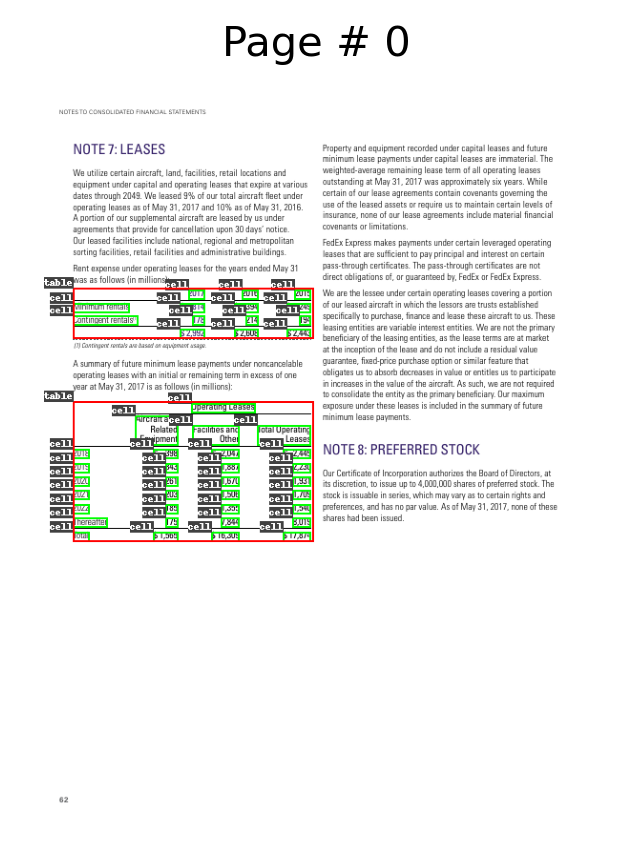

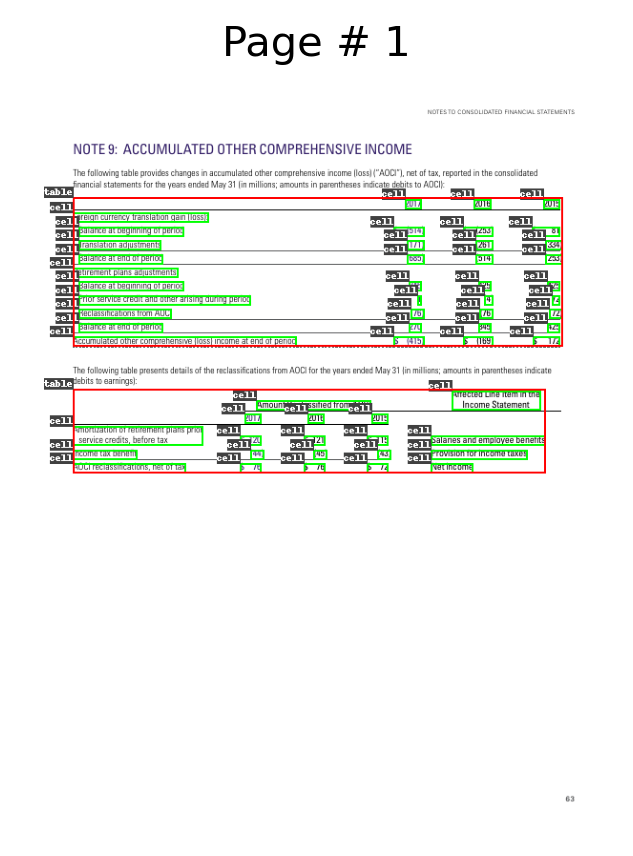

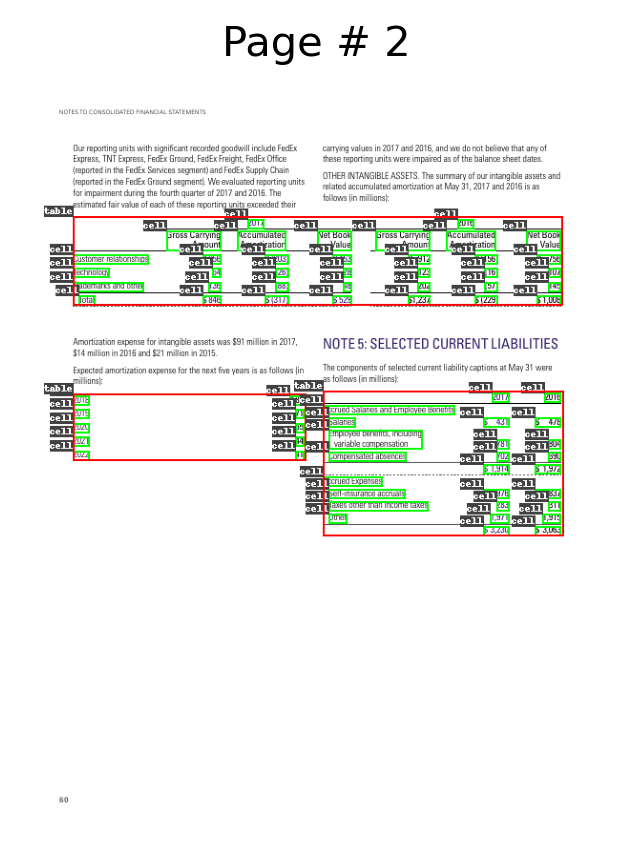

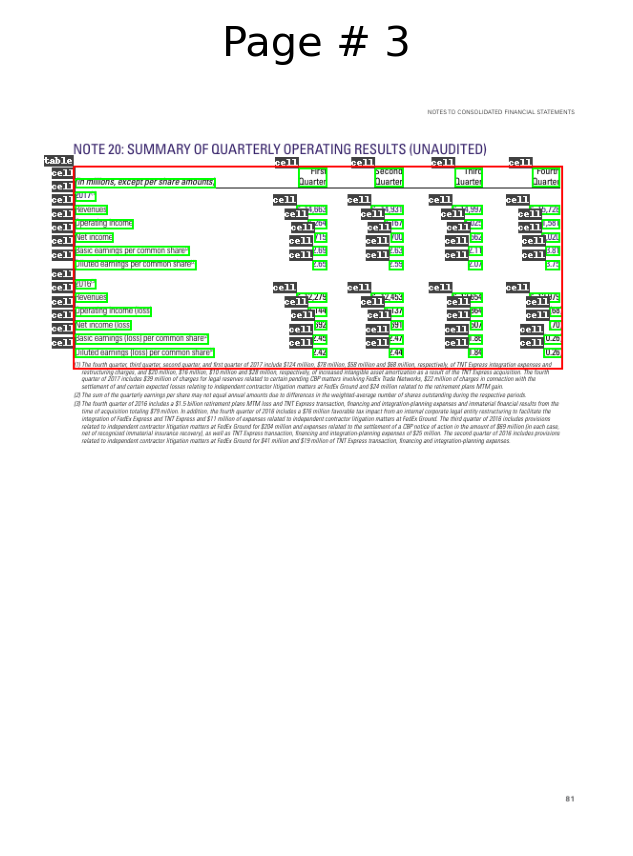

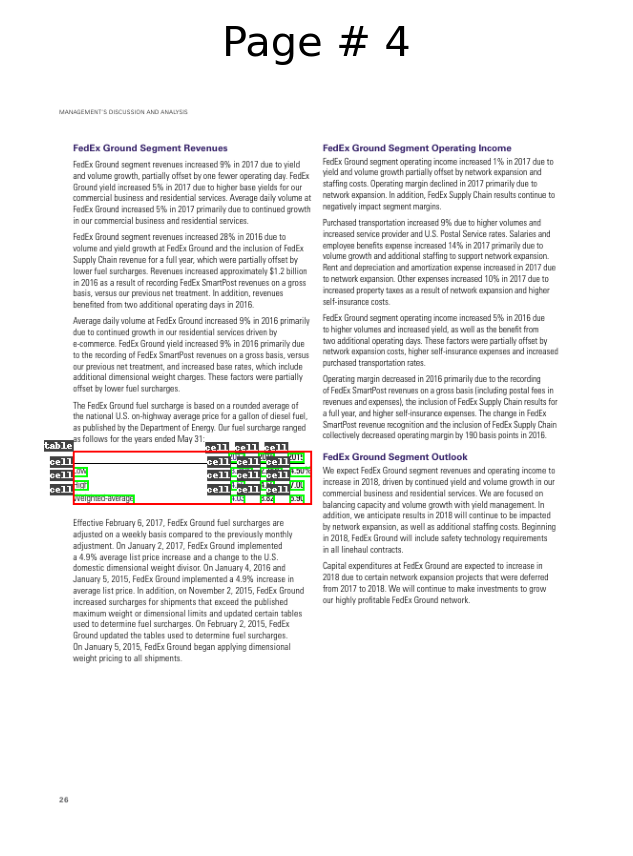

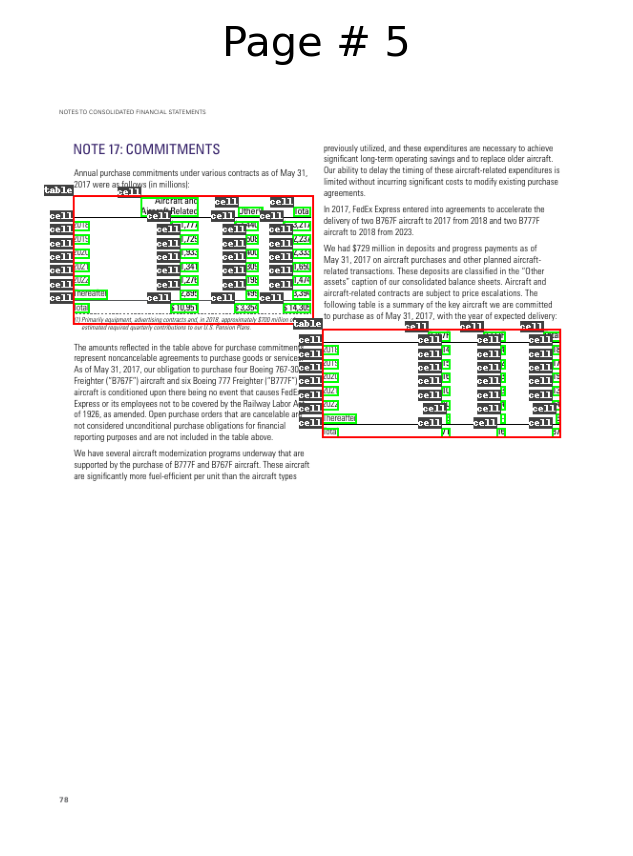

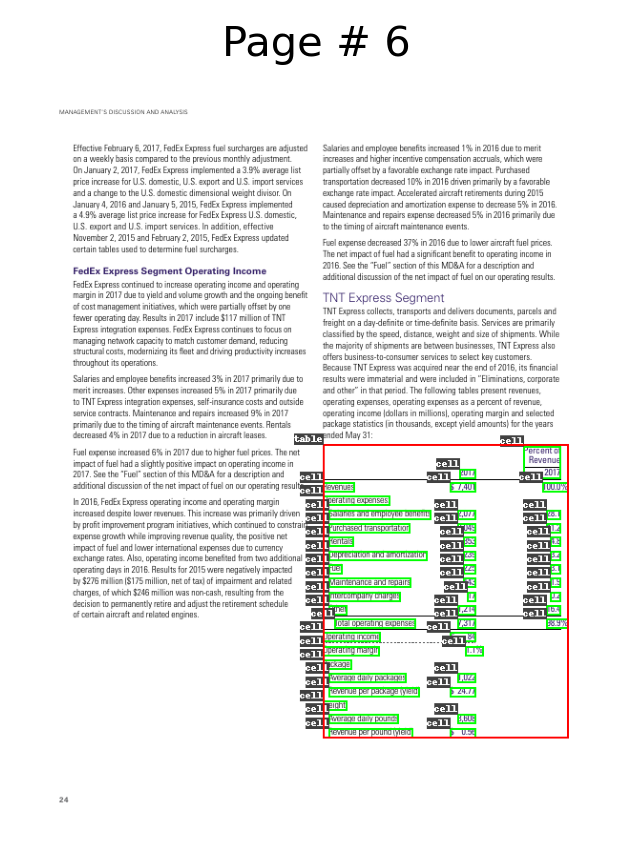

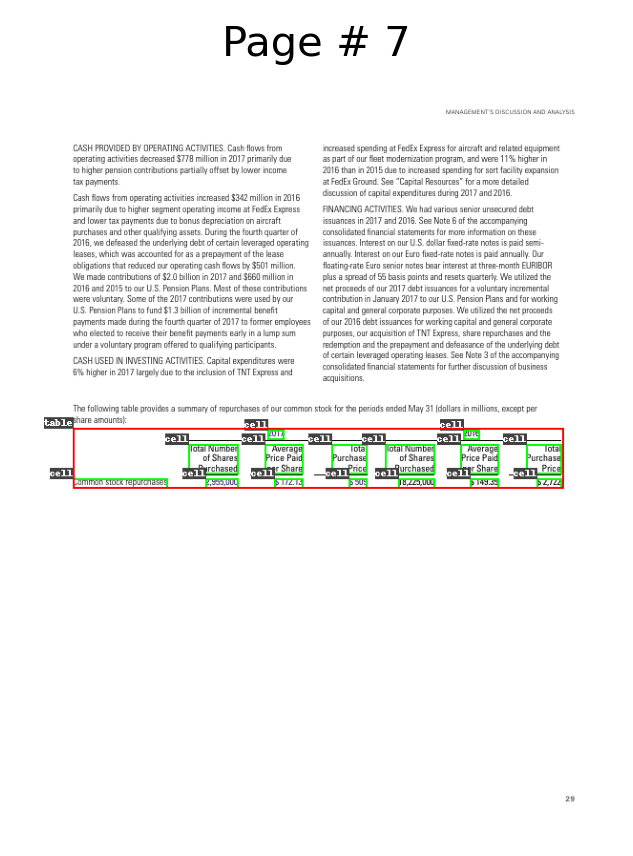

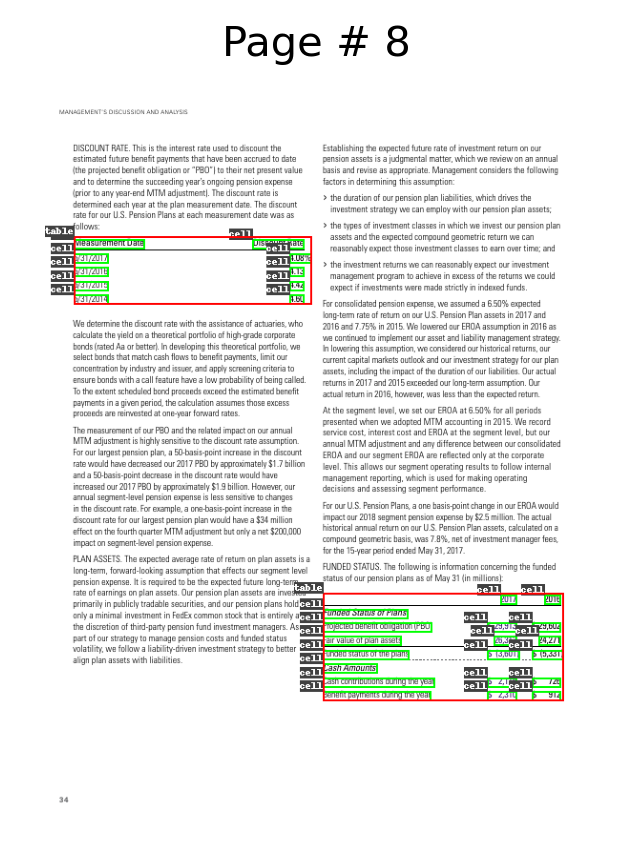

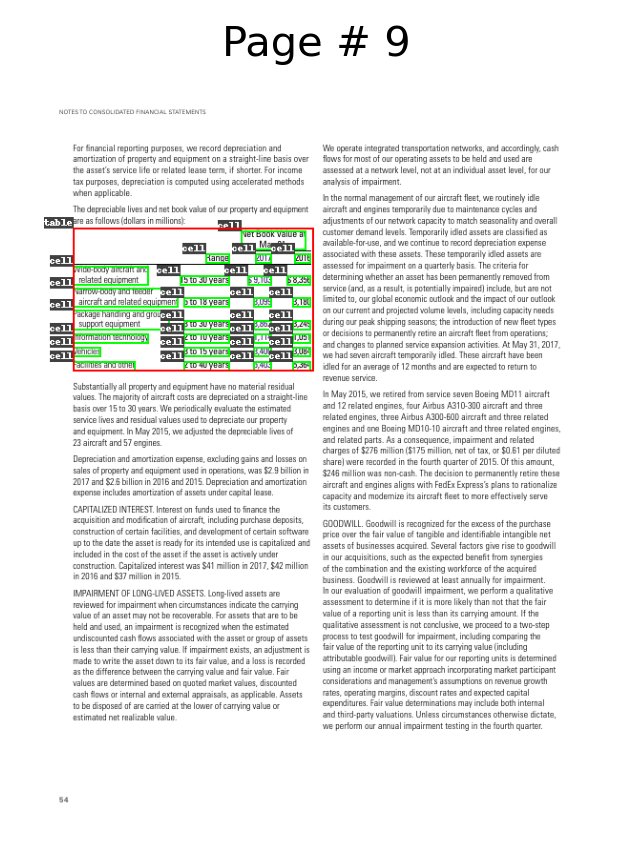

In [13]:
# Visualize annotations and print HTML tables
import matplotlib
matplotlib.rcParams['figure.dpi'] = 250
for i, (filename, image) in enumerate(images.items()):
    pdf_page = PdfFileReader(open(image["filepath"], 'rb')).getPage(0)
    pdf_shape = pdf_page.mediaBox
    pdf_height = pdf_shape[3]-pdf_shape[1]
    pdf_width = pdf_shape[2]-pdf_shape[0]
    converted_images = convert_from_path(image["filepath"], size=(pdf_width, pdf_height))
    img = converted_images[0]
    print("Table HTML for page #{}".format(i))
    display(HTML(image['html']))
    plt.figure()
    plt.imshow(markup(img, image['annotations'], pdf_height))
    plt.title("Page # {}".format(i))
    plt.axis('off')